# vivo vs. silico

author: steeve.laquitaine@epfl.ch  
date: 31.10.2023  

TODO:
- compare dist.
- compare stats: firing mean and std


## Setup

Activate `npx...` environment (select interpreter - find envs/ path - add kernel)

In [1]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import numpy as np
import os 
import pandas as pd
import spikeinterface as si
import warnings
import logging
import matplotlib
from pynwb import NWBHDF5IO
import spikeinterface.postprocessing as spost

# SET PROJECT PATH

PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/sfn_2023"
os.chdir(PROJ_PATH)
from src.nodes.utils import get_config
from src.nodes.postpro import spikestats

# SETUP EXPERIMENTS

# vivo
EXPERIMENT = "vivo_horvath"   
SIMULATION_DATE = "2021_file_1"
data_conf_horvath_1, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
RECORDING_PATH_HORVATH_1 = data_conf_horvath_1["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_VIVO_1 = data_conf_horvath_1["sorting"]["sorters"]["kilosort3"]["output"]
SORTED_FR_FILE_PATH_VIVO_1 = data_conf_horvath_1["features"]["sorted_ks3"]["firing_rates"]
STUDY_FOLDER_VIVO_1 = data_conf_horvath_1["postprocessing"]["waveform"]["study"]
SORTED_NEURON_METADATA_FILE_1 = data_conf_horvath_1["postprocessing"]["sorted_neuron_metadata"]

SIMULATION_DATE = "2021_file_2"
data_conf_horvath_2, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
RECORDING_PATH_HORVATH_2 = data_conf_horvath_2["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_VIVO_2 = data_conf_horvath_2["sorting"]["sorters"]["kilosort3"]["output"]
SORTED_FR_FILE_PATH_VIVO_2 = data_conf_horvath_2["features"]["sorted_ks3"]["firing_rates"]
SORTED_NEURON_METADATA_FILE_2 = data_conf_horvath_2["postprocessing"]["sorted_neuron_metadata"]

SIMULATION_DATE = "2021_file_3"
data_conf_horvath_3, _ = get_config(EXPERIMENT, SIMULATION_DATE).values()
RECORDING_PATH_HORVATH_3 = data_conf_horvath_3["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_VIVO_3 = data_conf_horvath_3["sorting"]["sorters"]["kilosort3"]["output"]
SORTED_FR_FILE_PATH_VIVO_3 = data_conf_horvath_3["features"]["sorted_ks3"]["firing_rates"]
SORTED_NEURON_METADATA_FILE_3 = data_conf_horvath_3["postprocessing"]["sorted_neuron_metadata"]

# silico
data_conf_silico_1, param_conf_silico_1 = get_config("silico_horvath", "probe_1").values()
RECORDING_PATH_SILICO_1 = data_conf_silico_1["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_SILICO_1 = data_conf_silico_1["sorting"]["sorters"]["kilosort3"]["output"]
SORTED_FR_FILE_PATH_SILICO_1 = data_conf_silico_1["features"]["sorted_ks3"]["firing_rates"]
SILICO_SORTED_METADATA_FILE_1 = data_conf_silico_1["postprocessing"]["sorted_neuron_metadata"]

data_conf_silico_2, param_conf_silico_2 = get_config("silico_horvath", "probe_2").values()
RECORDING_PATH_SILICO_2 = data_conf_silico_2["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_SILICO_2 = data_conf_silico_2["sorting"]["sorters"]["kilosort3"]["output"]
SORTED_FR_FILE_PATH_SILICO_2 = data_conf_silico_2["features"]["sorted_ks3"]["firing_rates"]
SILICO_SORTED_METADATA_FILE_2 = data_conf_silico_2["postprocessing"]["sorted_neuron_metadata"]

data_conf_silico_3, param_conf_silico_3 = get_config("silico_horvath", "probe_3").values()
RECORDING_PATH_SILICO_3 = data_conf_silico_3["preprocessing"]["output"]["trace_file_path"]
SORTED_PATH_SILICO_3 = data_conf_silico_3["sorting"]["sorters"]["kilosort3"]["output"]
SORTED_FR_FILE_PATH_SILICO_3 = data_conf_silico_3["features"]["sorted_ks3"]["firing_rates"]
SILICO_SORTED_METADATA_FILE_3 = data_conf_silico_3["postprocessing"]["sorted_neuron_metadata"]

# SETUP WAVEFORMS

MS_BEFORE = 3
MS_AFTER = 3

# SETUP PLOT 

# set lognormal plot parameters
log_x_min = -3.5
log_x_max = 2.0
nbins = 20

# IF you don't want to use the feature, set the value to 1E100
# t_dec = 3600 # seconds until experimenter decides a cell is silent
t_dec = 1^100 # seconds until experimenter decides a cell is silent

2023-11-03 18:48:42,667 - root - utils.py - get_config - INFO - Reading experiment config.
2023-11-03 18:48:42,675 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-11-03 18:48:42,676 - root - utils.py - get_config - INFO - Reading experiment config.
2023-11-03 18:48:42,682 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-11-03 18:48:42,683 - root - utils.py - get_config - INFO - Reading experiment config.
2023-11-03 18:48:42,690 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-11-03 18:48:42,691 - root - utils.py - get_config - INFO - Reading experiment config.
2023-11-03 18:48:42,716 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-11-03 18:48:42,717 - root - utils.py - get_config - INFO - Reading experiment config.
2023-11-03 18:48:42,730 - root - utils.py - get_config - INFO - Reading experiment config. - done
2023-11-03 18:48:42,731 - root - utils.py - get_config 

### Population

#### Compute

In [2]:
# SILICO
silico_paths = [SORTED_PATH_SILICO_1, SORTED_PATH_SILICO_2, SORTED_PATH_SILICO_3]

firing_rate_all = []
layer_all = []
depth_all = []
unit_id_all = []

for ix, sorted_path in enumerate(silico_paths):
    Sorting = si.load_extractor(sorted_path)
    # record
    unit_id_all += Sorting.unit_ids.tolist()
    firing_rate_all += Sorting.get_property("firing_rates").astype(np.float32).tolist()
    layer_all += Sorting.get_property("layer").tolist()
    depth_all += len(Sorting.unit_ids) * [ix + 1]

# store in dataframe
df_silico = pd.DataFrame(
    np.array(
        [
            depth_all,
            layer_all,
            firing_rate_all,
        ]
    ).T,
    index=unit_id_all,
    columns=[
        "depth",
        "layer",
        "firing_rate",
    ],
)

# VIVO

vivo_paths = [SORTED_PATH_VIVO_1, SORTED_PATH_VIVO_2, SORTED_PATH_VIVO_3]

firing_rate_all = []
layer_all = []
depth_all = []
unit_id_all = []

for ix, sorted_path in enumerate(vivo_paths):
    Sorting = si.load_extractor(sorted_path)
    # record
    unit_id_all += Sorting.unit_ids.tolist()
    firing_rate_all += Sorting.get_property("firing_rates").astype(np.float32).tolist()
    layer_all += Sorting.get_property("layer").tolist()
    depth_all += len(Sorting.unit_ids) * [ix + 1]

# store in dataframe
df_vivo = pd.DataFrame(
    np.array(
        [
            depth_all,
            layer_all,
            firing_rate_all,
        ]
    ).T,
    index=unit_id_all,
    columns=[
        "depth",
        "layer",
        "firing_rate",
    ],
)

#### Plot

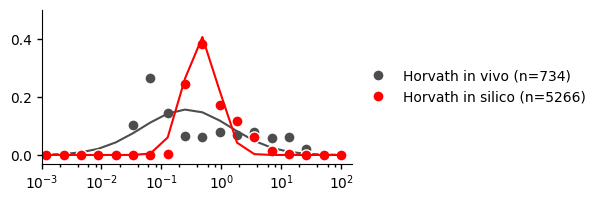

In [3]:
MARKERSIZE = 8
fig, axes = plt.subplots(1, 1, figsize=(4, 2))

# horvath
spikestats.plot_firing_rate_hist_vs_lognorm(
    df_vivo["firing_rate"].values.astype(np.float32),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes,
    label=f"""Horvath in vivo (n={len(df_vivo["firing_rate"].values.astype(np.float32))})""",
    color=(0.3, 0.3, 0.3),
    markerfacecolor=(0.3, 0.3, 0.3),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
# silico
spikestats.plot_firing_rate_hist_vs_lognorm(
    df_silico["firing_rate"].values.astype(np.float32),
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes,
    label=f"""Horvath in silico (n={len(df_silico["firing_rate"].values.astype(np.float32))})""",
    color=(1, 0, 0),
    markerfacecolor=(1, 0, 0),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
plt.legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))
plt.ylim([-0.03, 0.5])

# save figures
plt.savefig("figures/2_realism/4_firing_rate/pdf/all_sorted_horvath.pdf")
plt.savefig("figures/2_realism/4_firing_rate/svg/all_sorted_horvath.svg")

#### Plot

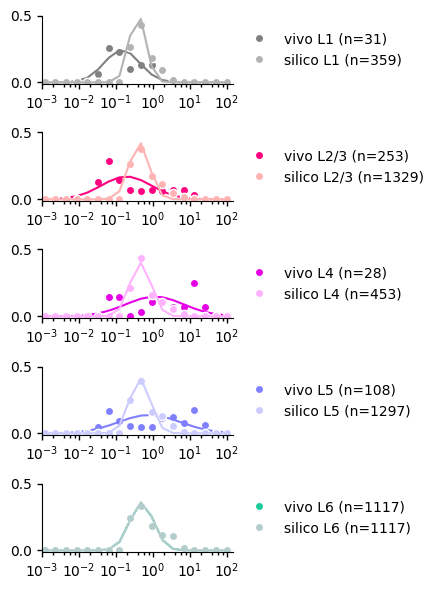

In [6]:
MARKERSIZE = 6
Y_MAX = 0.5

fig, axes = plt.subplots(5, 1, figsize=(4.5, 6))

# L1 -----
# vivo
y = df_vivo["firing_rate"][df_vivo["layer"] == "L1"].values.astype(np.float32)
spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label=f"vivo L1 (n={len(y)})",
    color=(0.5, 0.5, 0.5),
    markerfacecolor=(0.5, 0.5, 0.5),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
# silico
y = df_silico["firing_rate"][df_silico["layer"] == "L1"].values.astype(np.float32)
spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[0],
    label=f"silico L1 (n={len(y)})",
    color=(0.7, 0.7, 0.7),
    markerfacecolor=(0.7, 0.7, 0.7),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
axes[0].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))
axes[0].set_ylim([-0.01, Y_MAX])

# L2/3 -----
# vivo
y = df_vivo["firing_rate"][df_vivo["layer"] == "L2/3"].values.astype(np.float32)
spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label=f"vivo L2/3 (n={len(y)})",
    color=(1, 0, 0.5),
    markerfacecolor=(1, 0, 0.5),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
# silico
y = df_silico["firing_rate"][df_silico["layer"] == "L2/3"].values.astype(np.float32)
spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[1],
    label=f"silico L2/3 (n={len(y)})",
    color=(1, 0.7, 0.7),
    markerfacecolor=(1, 0.7, 0.7),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
axes[1].set_ylim([-0.01, Y_MAX])
axes[1].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))

# L4 -----
# vivo
y = df_vivo["firing_rate"][df_vivo["layer"] == "L4"].values.astype(np.float32)
spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label=f"vivo L4 (n={len(y)})",
    color=(0.9, 0, 0.9),
    markerfacecolor=(0.9, 0, 0.9),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
# silico
y = df_silico["firing_rate"][df_silico["layer"] == "L4"].values.astype(np.float32)
spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[2],
    label=f"silico L4 (n={len(y)})",
    color=(1, 0.7, 1),
    markerfacecolor=(1, 0.7, 1),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
axes[2].set_ylim([-0.01, Y_MAX])
axes[2].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))

# L5
# vivo
y = df_vivo["firing_rate"][df_vivo["layer"] == "L5"].values.astype(np.float32)
spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[3],
    label=f"vivo L5 (n={len(y)})",
    color=(0.5, 0.5, 1),
    markerfacecolor=(0.5, 0.5, 1),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
# silico
y = df_silico["firing_rate"][df_silico["layer"] == "L5"].values.astype(np.float32)
spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[3],
    label=f"silico L5 (n={len(y)})",
    color=(0.8, 0.8, 1),
    markerfacecolor=(0.8, 0.8, 1),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
axes[3].set_ylim([-0.01, Y_MAX])
axes[3].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))

# L6
# vivo
y = df_silico["firing_rate"][df_silico["layer"] == "L6"].values.astype(np.float32)
spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[4],
    label=f"vivo L6 (n={len(y)})",
    color=(0.1, 0.8, 0.6),
    markerfacecolor=(0.1, 0.8, 0.6),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
# silico
y = df_silico["firing_rate"][df_silico["layer"] == "L6"].values.astype(np.float32)
spikestats.plot_firing_rate_hist_vs_lognorm(
    y,
    log_x_min,
    log_x_max,
    nbins,
    t_dec,
    axes[4],
    label=f"silico L6 (n={len(y)})",
    color=(0.7, 0.8, 0.8),
    markerfacecolor=(0.7, 0.8, 0.8),
    markeredgecolor="w",
    linestyle="-",
    markersize=MARKERSIZE,
    legend=False,
    lognormal=True,
)
axes[4].set_ylim([-0.01, Y_MAX])
axes[4].legend(frameon=False, loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()